<a href="https://colab.research.google.com/github/nojihun/project1/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os.path
import numpy as np
import imageio
import cv2
from skimage import color, io
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
from pathlib import Path

In [2]:
drive.mount('/content/drive') # 구글 드라이브에 연동

Mounted at /content/drive


In [3]:
directory1 = '/content/drive/MyDrive/captcha'
file_list1 = os.listdir(directory1)# 구글 드라이브에서 폴더 읽기


In [ ]:
X=[] # 이 방법은 이미지를 한 글자씩으로 나누어서 각가을 학습을 시키는 것인데 문제는 이미지의 글자간의 간격이 변화하면 무쓸모가 ㅗ디낟.
y=[]

# Since there are subfolders inside the input directory, we've used nested loops
for dirname, _, filenames in os.walk(directory1):
    for filename in filenames[:10000]:
        path=os.path.join(dirname, filename) 
        
# Preprocessing the image:
# - read image
        image = cv2.imread(path,cv2.IMREAD_COLOR)


# - Blur: As in one-dimensional signals, images also can be filtered with various low-pass filters (LPF), high-pass filters (HPF), etc.
# LPF helps in removing noise, blurring images, etc. HPF filters help in finding edges in images.
        image = cv2.GaussianBlur(image, (5,5), 0)
 

# Splitting up the image into sections of each character
        x=[image[10:50,20:40],image[10:50,40:60],
                 image[10:50,60:80],image[10:50,80:100],image[10:50,100:120]]

# Labelling segments with the image name
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i])))
            y.append(path[len(path)-9:len(path)-4][i])
X=np.array(X)
y=np.array(y)


In [ ]:
X=X.astype('float32')
X/=255

y_le = LabelEncoder().fit_transform(y)
y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

In [ ]:
y.shape
X.shape

(50000, 30, 20, 3)

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))


model.add(Conv2D(filters=128,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2,2), padding ='same'))



model.add(Flatten())
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 20, 16)        448       
                                                                 
 activation (Activation)     (None, 30, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 15, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 5, 16)         0         
 2D)                                                    

In [ ]:
from keras.callbacks import EarlyStopping


batch_size = 150
epochs = 200
es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[es])

Epoch 1/200
267/267 [==============================] - 30s 108ms/step - loss: 3.8097 - accuracy: 0.0781 - val_loss: 3.5646 - val_accuracy: 0.1300
Epoch 2/200
267/267 [==============================] - 29s 108ms/step - loss: 3.2294 - accuracy: 0.1934 - val_loss: 3.0106 - val_accuracy: 0.2540
Epoch 3/200
267/267 [==============================] - 28s 106ms/step - loss: 2.8328 - accuracy: 0.2779 - val_loss: 2.6932 - val_accuracy: 0.3216
Epoch 4/200
267/267 [==============================] - 29s 108ms/step - loss: 2.5668 - accuracy: 0.3403 - val_loss: 2.4646 - val_accuracy: 0.3812
Epoch 5/200
267/267 [==============================] - 31s 117ms/step - loss: 2.3807 - accuracy: 0.3862 - val_loss: 2.3389 - val_accuracy: 0.4130
Epoch 6/200
267/267 [==============================] - 29s 107ms/step - loss: 2.2364 - accuracy: 0.4192 - val_loss: 2.2163 - val_accuracy: 0.4345
Epoch 7/200
267/267 [==============================] - 29s 108ms/step - loss: 2.1273 - accuracy: 0.4460 - val_loss: 2.1478 -

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 3s 11ms/step - loss: 1.8307 - accuracy: 0.5210
Test loss: 1.8307089805603027
Test accuracy: 0.5210000276565552


In [ ]:
def pred (img_path) :
    
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    image = cv2.GaussianBlur(img, (5,5), 0)
    
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0
    
    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)
    
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

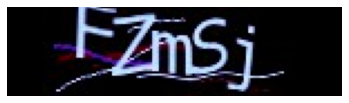

Prediction: FZmJC
Actual:     FZmSj


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

pred(directory1+'/'+'FZmSj.jpg')

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from skimage.transform import resize

In [ ]:
img= []
count = 0
for file in file_list1[:10000]:
  image = io.imread(directory1+'/'+ file)
  image = resize(image, (32, 128))  
  img.append(image)

In [ ]:
train = np.array(img)
train.shape

In [ ]:
train = np.resize(train, (10000, 34,128,3))

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train[i]))
    plt.gray()
plt.show()

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# gfg_logo.jpeg image opened using open
# function and assigned to variable named img
img = Image.open('/content/drive/MyDrive/white.jpg')
img = img.resize((150,40))
# Image is converted into editable form using
# Draw function and assigned to d1
d1 = ImageDraw.Draw(img)
fontsize = 36
font = ImageFont.truetype("/content/drive/MyDrive/arial.ttf", fontsize)
# Decide the text location, color and font
d1.text((20, 0), "Fg1zg", fill =(0, 0, 0), font = font)
 
# show and save the image
img.show()
img.save("/content/drive/MyDrive/results.jpg")


In [ ]:
def image_make(text):
  img = Image.open('/content/drive/MyDrive/white.jpg')
  img = img.resize((128,32))
  d1 = ImageDraw.Draw(img)
  fontsize = 36
  font = ImageFont.truetype("/content/drive/MyDrive/arial.ttf", fontsize)
  d1.text((20, 0), text, fill =(0, 0, 0), font = font)
  return img

In [ ]:
label = []
for i in file_list1[:10000]:
  i = i.replace('.jpg','')
  img = image_make(i)
  img = np.array(img)
  label.append(img)


In [ ]:
label = np.array(label)
label.shape

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf


import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [ ]:
train_horses

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image
# 이미지의 특정 부위를 랜덤하게 잘라내는 기능


# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image
#이미지의 값의 범위를 0~255가 아니라 -1~1 사이의 값으로 변경하는 기능


def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image
# 지터링, 즉 데이터 사이즈를 키워서 임의의 공간을 잘라내서 flip을 하여, 같은 이미지도 약간씩 모양이 다르도록 하여 마치 데이터 개수가 늘어난 것처럼 하는 데이터 증강 기법


def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image
# 지터링과 데이터 normalize를 동시에 적용하는 기능
def preprocess_image_test(image, label):
  image = normalize(image)
  return image
# 그냥 normalize만 하는 기능.



In [ ]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
train_horses

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

In [ ]:
sample_horse = next(iter(train))
sample_zebra = next(iter(label))

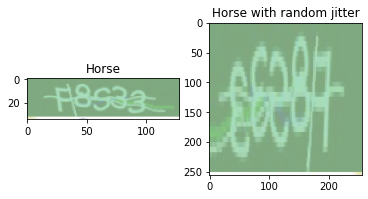

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(train[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(train[0]) * 0.5 + 0.5)

ValueError: ignored

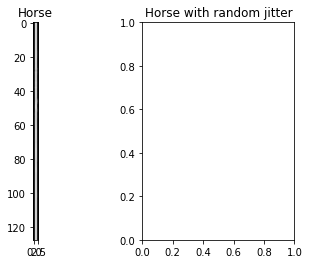

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
to_zebra = generator_g(train)
to_horse = generator_f(label)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [train, to_zebra, label, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
 

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)
  

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/train"


ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
EPOCHS = 40
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

 

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 128, 3)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
pip install tensorflow_addons

In [ ]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

In [ ]:
class Denoise(Model):
  def __init__(self):
    K.clear_session()
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 128, 3)),
      layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2), padding ='same'),
      layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2), padding ='same'),
      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2), padding ='same'),
      layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2), padding ='same'),          
      layers.Conv2D(8, (3,3), activation='relu', padding='same'),
      layers.Conv2D(8, (3,3), activation='relu', padding='same'),
      layers.Conv2D(8, (3,3), activation='relu', padding='same'),
      layers.Conv2D(8, (3,3), activation='relu', padding='same')
      ])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(512, kernel_size=3, strides=1, activation='relu', padding='same'),  
      layers.Conv2DTranspose(3, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
autoencoder.compile(optimizer=opt, loss='mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001)


history = autoencoder.fit(x_train, y_train,
          epochs=20,
          batch_size=8, 
          validation_data=(x_test, y_test),
          callbacks= [cb_lr_schedule, early_stopping], 
          shuffle=True)

Epoch 1/20
  14/1000 [..............................] - ETA: 3:56:22 - loss: 50351.3633 - root_mean_squared_error: 224.3912

KeyboardInterrupt: ignored

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 16, 16, 16)        448       
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 8)           1160      
                                                                 
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

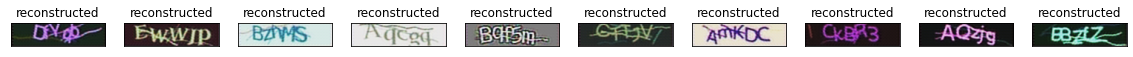

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):



    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.fit(x_train, y_train,
                epochs=200,
                batchsize = 150,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/10
250/250 [==============================] - 49s 197ms/step - loss: 50175.8164 - val_loss: 50172.3125
Epoch 2/10
250/250 [==============================] - 76s 305ms/step - loss: 50174.1602 - val_loss: 50172.3125
Epoch 3/10
250/250 [==============================] - 49s 195ms/step - loss: 50174.1484 - val_loss: 50172.3125
Epoch 4/10
250/250 [==============================] - 50s 199ms/step - loss: 50174.1641 - val_loss: 50172.3125
Epoch 5/10
250/250 [==============================] - 49s 196ms/step - loss: 50174.1562 - val_loss: 50172.3125
Epoch 6/10
250/250 [==============================] - 49s 196ms/step - loss: 50174.1680 - val_loss: 50172.3125
Epoch 7/10
250/250 [==============================] - 51s 202ms/step - loss: 50174.1562 - val_loss: 50172.3125
Epoch 8/10
250/250 [==============================] - 49s 196ms/step - loss: 50174.1523 - val_loss: 50172.3125
Epoch 9/10
250/250 [==============================] - 49s 195ms/step - loss: 50174.1602 - val_loss: 50172.3125
E